# Introduction to Optimal Transport with Python

#### *Rémi Flamary, Nicolas Courty*

## POT installation

+ Install with pip:
```bash
pip install pot
```
+ Install with conda
```bash
conda install -c conda-forge pot
```

## POT Python Optimal Transport Toolbox

#### Import the toolbox

In [10]:
import numpy as np # always need it
import scipy as sp # often use it
import matplotlib.pyplot as pl # do the plots

import ot # ot 

#### Getting help

Online  documentation : [http://pot.readthedocs.io](http://pot.readthedocs.io) 

Or inline help:


In [3]:
help(ot.dist)

Help on function dist in module ot.utils:

dist(x1, x2=None, metric='sqeuclidean', p=2, w=None)
    Compute distance between samples in :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`

    .. note:: This function is backend-compatible and will work on arrays
        from all compatible backends.

    Parameters
    ----------

    x1 : array-like, shape (n1,d)
        matrix with `n1` samples of size `d`
    x2 : array-like, shape (n2,d), optional
        matrix with `n2` samples of size `d` (if None then :math:`\mathbf{x_2} = \mathbf{x_1}`)
    metric : str | callable, optional
        'sqeuclidean' or 'euclidean' on all backends. On numpy the function also
        accepts  from the scipy.spatial.distance.cdist function : 'braycurtis',
        'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice',
        'euclidean', 'hamming', 'jaccard', 'kulczynski1', 'mahalanobis',
        'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
        'sokalmichener',

## First OT Problem

We will solve the Bakery/Cafés problem of transporting croissants from a number of Bakeries to Cafés in a City (In this case Manhattan). We did a quick google map search in Manhattan for bakeries and Cafés:

![bak.png](https://remi.flamary.com/cours/otml/bak.png)

We extracted from this search their positions and generated fictional production and sale number (that both sum to the same value).

We have acess to the position of Bakeries ```bakery_pos``` and their respective production ```bakery_prod``` which describe the source distribution. The Cafés where the croissants are sold are defiend also by their position ```cafe_pos``` and ```cafe_prod```. For fun we also provide a map ```Imap``` that will illustrate the position of these shops in the city.


Now we load the data



In [4]:
data=np.load('data/manhattan.npz')

bakery_pos=data['bakery_pos']
bakery_prod=data['bakery_prod']
cafe_pos=data['cafe_pos']
cafe_prod=data['cafe_prod']
Imap=data['Imap']

print('Bakery production: {}'.format(bakery_prod))
print('Cafe sale: {}'.format(cafe_prod))
print('Total croissants : {}'.format(cafe_prod.sum()))

Bakery production: [31. 48. 82. 30. 40. 48. 89. 73.]
Cafe sale: [82. 88. 92. 88. 91.]
Total croissants : 441.0


#### Plotting bakeries in the city

Next we plot the position of the bakeries and cafés on the map. The size of the circle is proportional to their production.


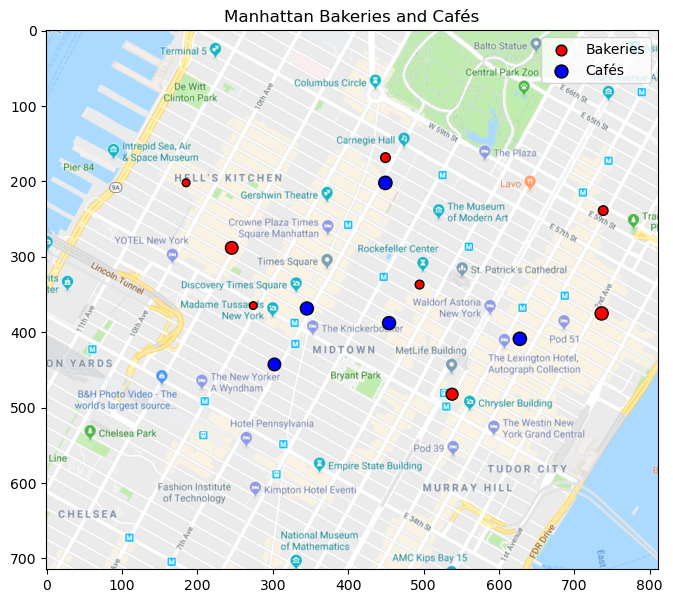

In [11]:
pl.figure(1,(8,7))
pl.clf()
pl.imshow(Imap,interpolation='bilinear') # plot the map
pl.scatter(bakery_pos[:,0],bakery_pos[:,1],s=bakery_prod,c='r', edgecolors='k',label='Bakeries')
pl.scatter(cafe_pos[:,0],cafe_pos[:,1],s=cafe_prod,c='b', edgecolors='k',label='Cafés')
pl.legend()
pl.title('Manhattan Bakeries and Cafés')

#### Cost matrix


We compute the cost matrix between the bakeries and the cafés, this will be the transport cost matrix. This can be done using the [ot.dist](http://pot.readthedocs.io/en/stable/all.html#ot.dist) that defaults to squared euclidean distance but can return other things such as cityblock (or manhattan distance). 



In [23]:
distance_matrix = ot.dist(bakery_pos, cafe_pos, metric="cityblock")
print(distance_matrix)

[[358.1894393  326.95645073 264.4904736  455.35873707 649.69733261]
 [421.64305156 304.34582782  33.6599269  224.28322576 418.62182129]
 [211.33120771 180.09821915 289.98499106 308.50050548 502.83910102]
 [106.2336107   75.00062213 338.00972082 203.40290847 397.741504  ]
 [298.44917956 181.15195583 180.26028463  91.6173886  204.94657438]
 [640.1903725  522.89314877 325.72649506 433.35858154 280.66397076]
 [501.68426783 397.59055914 460.05653628 294.85247686 142.15786609]
 [275.18018508 306.41317365 368.87915079 178.01088732 163.39077689]]


#### Solving the OT problem with [ot.emd](http://pot.readthedocs.io/en/stable/all.html#ot.emd)

In [16]:
P = ot.emd(bakery_prod, cafe_prod, M=distance_matrix, numItermax= 10000, numThreads=4)

In [22]:
print(P)
print("Checking the marginals: P#a=b", f" {P.sum(axis=1)} = {bakery_prod}")
print("Checking the marginals: P#b=a", f" {P.sum(axis=0)} = {cafe_prod}")

[[31.  0.  0.  0.  0.]
 [ 0.  0. 48.  0.  0.]
 [ 0. 82.  0.  0.  0.]
 [24.  6.  0.  0.  0.]
 [ 0.  0.  0. 40.  0.]
 [ 0.  0. 44.  0.  4.]
 [ 0.  0.  0.  2. 87.]
 [27.  0.  0. 46.  0.]]
Checking the marginals: P#a=b  [31. 48. 82. 30. 40. 48. 89. 73.] = [31. 48. 82. 30. 40. 48. 89. 73.]
Checking the marginals: P#b=a  [82. 88. 92. 88. 91.] = [82. 88. 92. 88. 91.]


#### Transportation plan vizualization

A good vizualization of the OT matrix in the 2D plane is to denote the transportation of mass between a Bakery and a Café by a line. This can easily be done with a double ```for``` loop.

In order to make it more interpretable one can also use the ```alpha``` parameter of plot and set it to ```alpha=G[i,j]/G[i,j].max()```. 

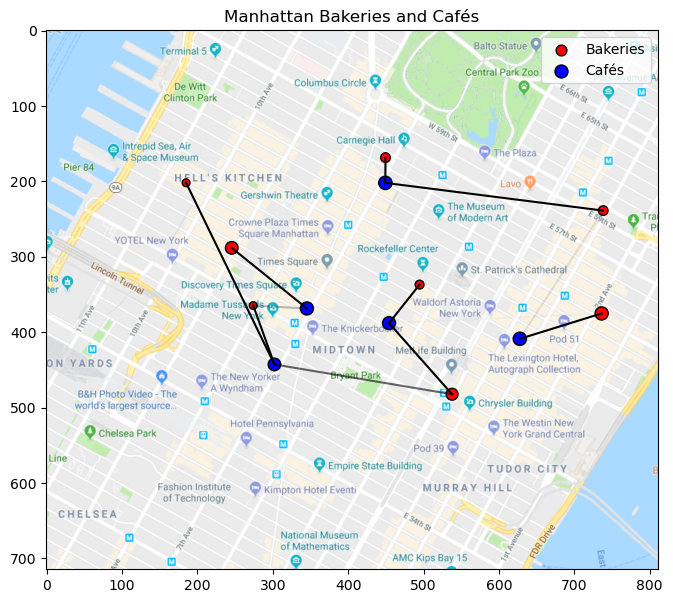

In [35]:
alpha = P / P.max(axis=1)[:, np.newaxis]
pl.figure(1,(8,7))
pl.clf()
pl.imshow(Imap,interpolation='bilinear') # plot the map
pl.scatter(bakery_pos[:,0],bakery_pos[:,1],s=bakery_prod,c='r', edgecolors='k',label='Bakeries')
pl.scatter(cafe_pos[:,0],cafe_pos[:,1],s=cafe_prod,c='b', edgecolors='k',label='Cafés')

for i in range(len(bakery_pos)):
    for j in range(len(cafe_pos)):
        pl.plot([bakery_pos[i, 0], cafe_pos[j, 0]], [bakery_pos[i, 1], cafe_pos[j, 1]], 'k-', alpha=alpha[i,j])

pl.legend()
pl.title('Manhattan Bakeries and Cafés')
pl.show()

#### OT loss and dual variables

The resulting wasserstein loss loss is of the form:

$W=\sum_{i,j}\gamma_{i,j}C_{i,j}$

where $\gamma$ is the optimal transport matrix.


In [40]:
W = np.sum(P * distance_matrix)
W

78182.3357959406

#### Regularized OT with SInkhorn

The Sinkhorn algorithm is very simple to code. You can implement it directly using the following pseudo-code:

![sinkhorn.png](http://remi.flamary.com/cours/otml/sink.png)

An alternative is to use the POT toolbox with [ot.sinkhorn](http://pot.readthedocs.io/en/stable/all.html#ot.sinkhorn)

Be carefull to numerical problems. A good pre-provcessing for Sinkhorn is to divide the cost matrix ```C```
 by its maximum value.

In [145]:
def sinkhorn(a, b, M, reg, n_it=100):
    u = np.ones_like(bakery_prod)
    K = np.exp(-1/reg * distance_matrix)
    for _ in range(n_it):
        v = b / (K.T @ u) #Update right scaling
        u = a / (K @ v)
    return np.diag(u) @ K @ np.diag(v)    

In [150]:
C = ot.utils.cost_normalization(distance_matrix, norm="max")
P_sinkhorn = sinkhorn(bakery_prod, cafe_prod, C, reg=1.5e-2, n_it=5000)
np.set_printoptions(suppress=True)
print(P_sinkhorn)
print(P_sinkhorn.sum(axis=0))
print(P_sinkhorn.sum(axis=1))

[[12.41890152 18.45114272  0.1299557   0.00000005  0.        ]
 [ 0.          0.00000358 47.99997612  0.00002029  0.        ]
 [32.98828842 49.01171143  0.00000001  0.00000014  0.        ]
 [12.06888601 17.93111394  0.          0.00000005  0.        ]
 [ 0.00024638  2.50543978  0.00003182 37.49428203  0.        ]
 [ 0.00000061  0.00618907 43.87003635  0.09262035  4.03115362]
 [ 0.00001313  0.03444719  0.          1.99817438 86.96736529]
 [24.52366393  0.05995228  0.         48.4149027   0.00148109]]
[82. 88. 92. 88. 91.]
[31. 48. 82. 30. 40. 48. 89. 73.]


In [151]:
sinkhorn_better = ot.sinkhorn(bakery_prod, cafe_prod, C, reg=1.5e-2, numItermax=5000)
print(sinkhorn_better)
print(sinkhorn_better.sum(axis=1))
print(sinkhorn_better.sum(axis=0))

[[12.41890152 18.45114272  0.1299557   0.00000005  0.        ]
 [ 0.          0.00000358 47.99997612  0.00002029  0.        ]
 [32.98828842 49.01171143  0.00000001  0.00000014  0.        ]
 [12.06888601 17.93111394  0.          0.00000005  0.        ]
 [ 0.00024638  2.50543978  0.00003182 37.49428203  0.        ]
 [ 0.00000061  0.00618907 43.87003635  0.09262035  4.03115362]
 [ 0.00001313  0.03444719  0.          1.99817438 86.96736529]
 [24.52366393  0.05995228  0.         48.4149027   0.00148109]]
[31. 48. 82. 30. 40. 48. 89. 73.]
[82. 88. 92. 88. 91.]


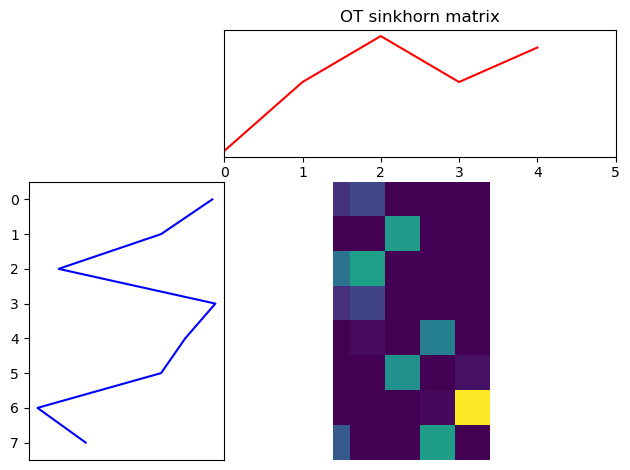

In [152]:
import ot.plot as otplt
otplt.plot1D_mat(bakery_prod, cafe_prod, P_sinkhorn, "OT sinkhorn matrix")